In [1]:
import argparse
import yaml
from tqdm import tqdm
import sys

import pickle

import jax
import jax.numpy as jnp
import optax   

import math
import numpy as np
import matplotlib.pyplot as plt

from helpers.data import get_pdf_toy, read_in_data_JAX

# Params and Initialization

### @RADHA, IMPORTANT CHANGE

I made it so mstar is the lowest power of alpha that can appear in either g_star or g_mn.

If mstar = 1, then the 0th row of both matrices correspond to alpha^1 terms.

If mstar = 0, then the 0th row of both matrices correspond to alpha^0 terms. 

Look at `utils.distribution_utils.build_q_mstar`to see how this works. 

In [2]:
# TODO: Replace this with Radha's YAML files
mstar = 1
m = 2
n = 3

lr = 0.001
weight_decay = 0.001
epochs = 5000
batch_size = 320
seed = 42

# Seed stuff
np.random.seed(seed)
jax_key = jax.random.PRNGKey(seed)


# Initialize params
params = {
    "g_star" : -np.ones((m+1 - mstar, n+1)) * 0.1,
    "g_coeffs" : -np.ones((m+1 - mstar, n+1)) * 0.1,
    "thetas" : np.zeros((m+1 - mstar,)),
}



# # For flavor, slightly smarter inits

signs = (-1) * np.power(-1, np.arange(n + 1) % 2)
params["g_star"][0,1] = -1
params["thetas"][0] = 0.5
params["thetas"][1] = 0.1

for mi in range(m+1-mstar):
    params["g_star"][mi] *= signs
    params["g_coeffs"][mi] *= signs



# factorials = np.ones_like(params["g_star"])
# for mi in range(params["g_star"].shape[0]):
#     for ni in range(params["g_star"].shape[1]):
#         factorials[mi, ni] = 1/math.factorial(mi) / math.factorial(ni)
#         g_star = np.random.normal(size = params["g_star"].shape) * factorials
#         g_coeffs = np.random.normal(size = params["g_coeffs"].shape) #* factorials / 10
#         thetas = params["thetas"]
#         thetas[1:] = np.random.uniform(size = (thetas.shape[0] - 1,))

#         params = {
#             "g_star" : g_star,
#             "g_coeffs" : g_coeffs,
#             "thetas" : thetas,
#         }




No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Compilation 

Notation:
Functions with the postfix `vmap` are vmapped in `t` but NOT `alpha`. So you can run it for a batch of `ts` but with a SCALAR `alpha`

Functions with the postfix `vmap2` are vmapped in `t` and `alpha` seperately. So you can run it for a batch of N `ts` and a batch of `M` alphas, and the result will be an (M, N) array.

In [3]:
from utils.function_utils import polynomial, taylor_expand_in_alpha
from utils.distribution_utils import build_q_mstar, log_q, f
from rikabplotlib.plot_utils import newplot

q = build_q_mstar(mstar)

# compile
q_vmap = jax.vmap(q, in_axes=(0,None,None,None, None))
f_vmap = jax.vmap(f, in_axes=(0,None,None,None, None))
polynomial_vmap = jax.vmap(polynomial, in_axes=(0,None,None,None))


# Taylor Expansions
q0_vmap = jax.vmap(taylor_expand_in_alpha(q, 0), in_axes=(0,None,None,None,None))
q1_vmap = jax.vmap(taylor_expand_in_alpha(q, 1), in_axes=(0,None,None,None,None))
q2_vmap = jax.vmap(taylor_expand_in_alpha(q, 2), in_axes=(0,None,None,None,None))
q3_vmap = jax.vmap(taylor_expand_in_alpha(q, 3), in_axes=(0,None,None,None,None))
# ... Add more if necessary, can loop if we really have to

qm_vmap = [q0_vmap, q1_vmap, q2_vmap, q3_vmap]

# ##### Second vmap over alpha #####
q_vmap2 = jax.vmap(q_vmap, in_axes = (None, 0, None, None, None))
qm_vmap2 = []
for qi in qm_vmap:
    qi_vmap2 = jax.vmap(qi, in_axes = (None, 0, None, None, None))
    qm_vmap2.append(qi_vmap2)



# Select the Taylor Expansion Function
CHOSEN_Q_VMAP = qm_vmap[m]
CHOSEN_Q_VMAP2 = qm_vmap2[m]


# Data Setup

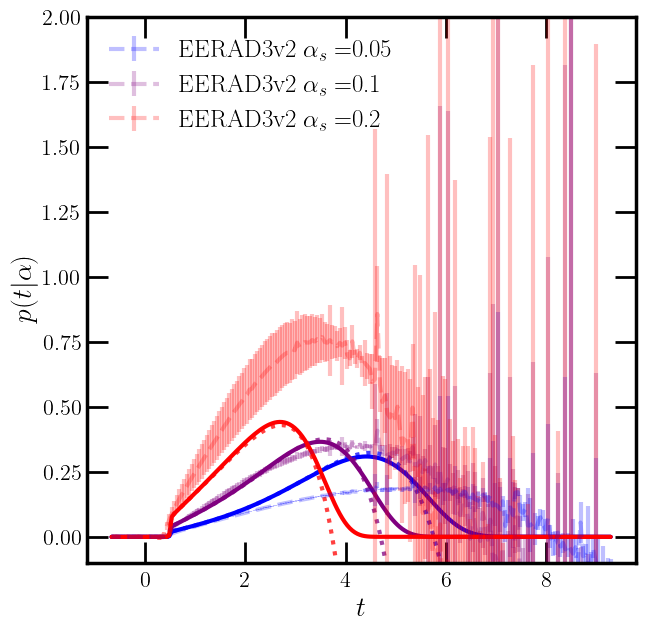

In [4]:
data_dict, t_bins, t_bin_centers = read_in_data_JAX("thrust", m)

alpha_keys = np.array(list(data_dict.keys()))
alpha_keys_float = list(data_dict.keys())

t_min = jnp.min(t_bins)
t_max = jnp.max(t_bins)


# Keys of interest
keys = np.array([0.05, 0.1, 0.2])

# Find the keys in the list closest to these values (to deal with floating point errors)
for (k, key) in enumerate(keys):

    closest_key = alpha_keys_float[np.argmin(np.abs(key - alpha_keys))]
    keys[k] = closest_key


# Make an array of ys and yerrs so we dont have to keep the dictionary around
ys = []
yerrs = []
for key in alpha_keys_float:
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]

    # clamp yerr by its nonzero minimum

    min_y_err = np.min(yerr[yerr > 0])
    yerr = np.clip(yerr, a_min=min_y_err.item(), a_max=None)
    
    ys.append(y)
    yerrs.append(yerr)

ys = jnp.array(ys)
yerrs = jnp.array(yerrs)


# Make a plot of the data 
colors = ["blue", "purple", "red"]
fig, ax = newplot("full")
q_vals = q_vmap2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])
q_taylor_vals = CHOSEN_Q_VMAP2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])

for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]
    plt.errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
    plt.plot(t_bin_centers, q_vals[k], color = colors[k])
    plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")

plt.ylim(-0.1, 2)
# plt.xscale("log")
plt.xlabel(r"$t$")
plt.ylabel(r"$p(t | \alpha)$")
plt.legend(loc = "upper left")



# Loss and Training

In [5]:
# Set up the loss as a function of the parameters

loss_epsilon = 1e-12

# Weighted MSE
def loss_function(params):

    y_preds = jnp.nan_to_num(CHOSEN_Q_VMAP2(t_bin_centers, alpha_keys, params["g_star"], params["g_coeffs"], params["thetas"]))
    mean_errors = jnp.mean(yerrs)
    y_errs_rescaled = yerrs / mean_errors

    return jnp.mean((y_preds - ys)**2 /(y_errs_rescaled**2 + loss_epsilon)) / 2


print("Initial Loss: ", loss_function(params))


Initial Loss:  52110.137


### BOGO Initializer

In [ ]:
bogo_epochs = 1000

best_loss = loss_function(params)
best_params = params.copy()

factorials = []
for mi in range(params["g_star"].shape[0]):
    for ni in range(params["g_star"].shape[1]):
        factorials[mi, ni] = 1 / math.factorial(mi + mstar) / math.factorial(ni)


for epoch in range(bogo_epochs):


    loss = loss_function(params)
    if loss < best_loss:
        best_loss = loss
        best_params = params.copy()

    else:

        # Initialize params
        jax_key, subkey1, subkey2, subkey3 = jax.random.split(jax_key, 4)

        g_star = np.random.normal(size = params["g_star"].shape) * factorials
        g_coeffs = np.random.normal(size = params["g_coeffs"].shape)  * factorials

        # Choose signs nicely
        for ni in range(g_star.shape[1]):

            if n % 0 == 2:
                g_star[:,n] = -np.abs(g_star[:,n])
                g_coeffs[:,n] = -np.abs(g_coeffs[:,n])
            else:
                g_star[:,n] = np.abs(g_star[:,n])
                g_coeffs[:,n] = np.abs(g_coeffs[:,n])


        thetas = params["thetas"]
        thetas[1:] = np.random.uniform(size = (thetas.shape[0] - 1,))

        params = {
            "g_star" : g_star,
            "g_coeffs" : g_coeffs,
            "thetas" : thetas,
        }

    print("BOGO Epoch", epoch, "Loss =", loss, "Best Loss =", best_loss)

params = best_params.copy()
print(params)



### Real Training

Note due to compilation, epoch 1 should take a long time, but every subsequent epoch should be faster

  0%|          | 0/5000 [00:00<?, ?it/s]

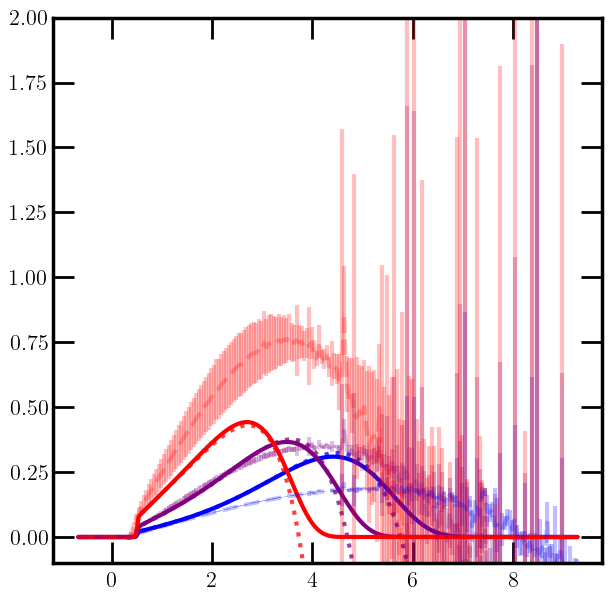

 4369.9902:   1%|          | 50/5000 [00:13<10:54,  7.57it/s]  

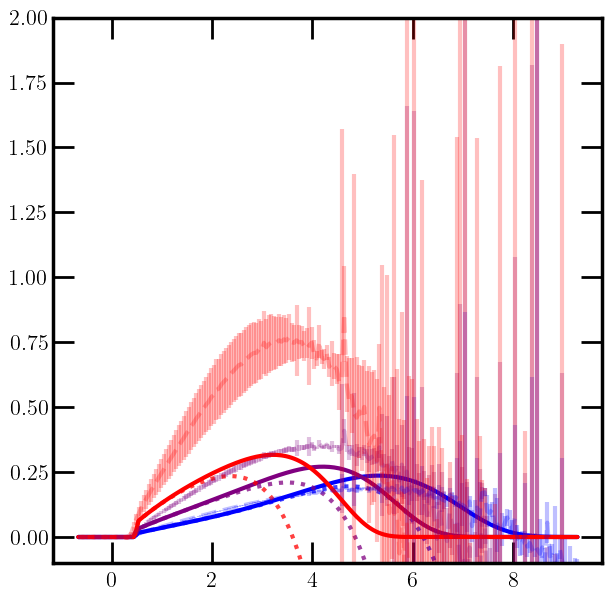

 764.4468:   2%|▏         | 100/5000 [00:20<12:22,  6.60it/s]

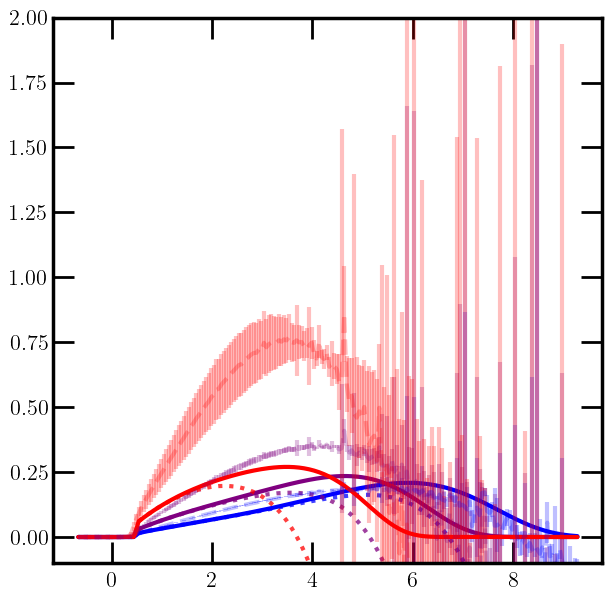

 699.9183:   3%|▎         | 150/5000 [00:28<11:52,  6.81it/s]

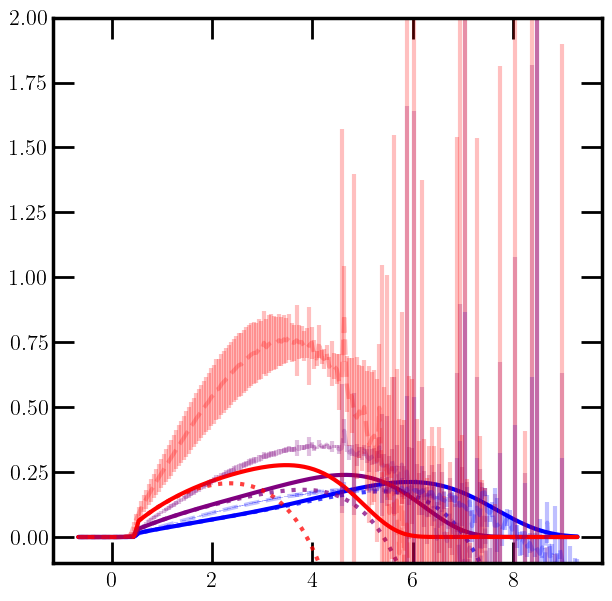

 652.3881:   4%|▍         | 200/5000 [00:36<11:57,  6.69it/s]

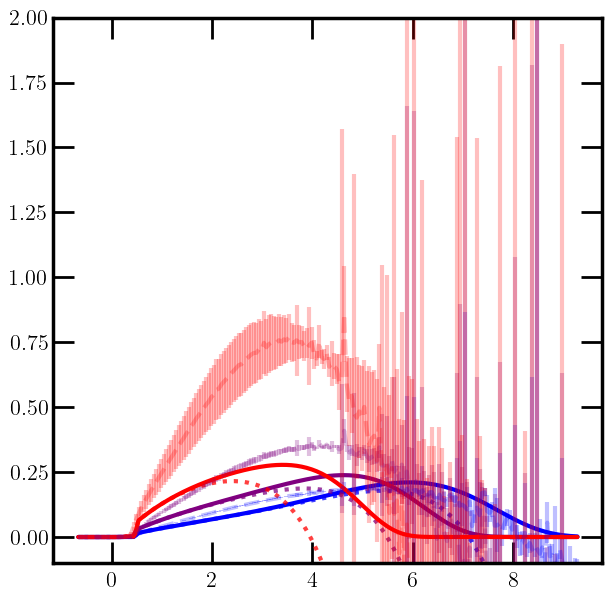

 609.6032:   5%|▌         | 250/5000 [00:44<11:39,  6.79it/s]

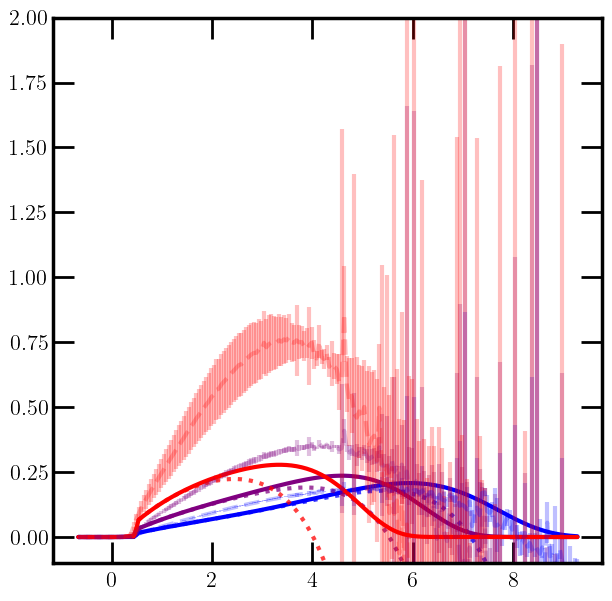

 570.6108:   6%|▌         | 300/5000 [00:51<10:24,  7.53it/s]

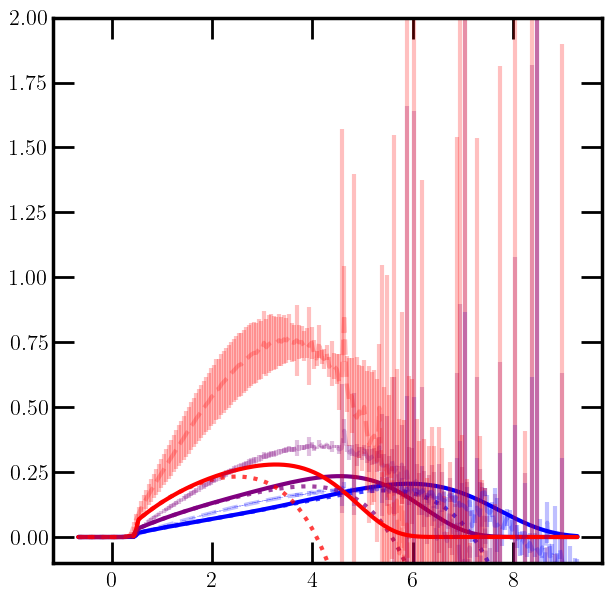

 534.7654:   7%|▋         | 350/5000 [00:58<10:09,  7.63it/s]

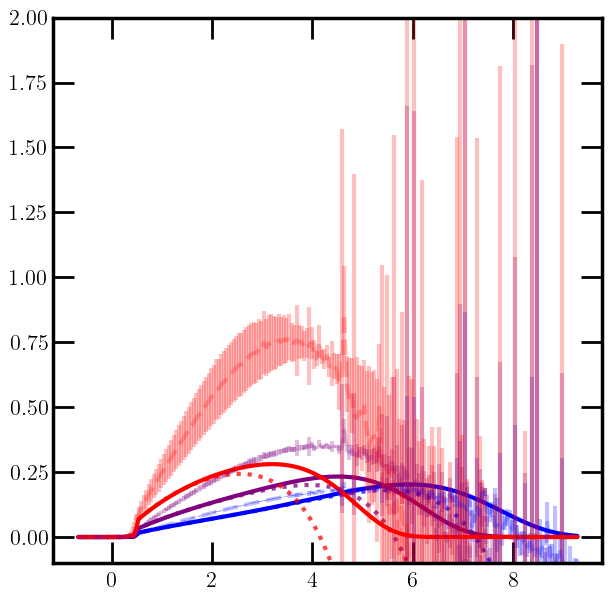

 500.9859:   8%|▊         | 400/5000 [01:06<09:55,  7.72it/s]

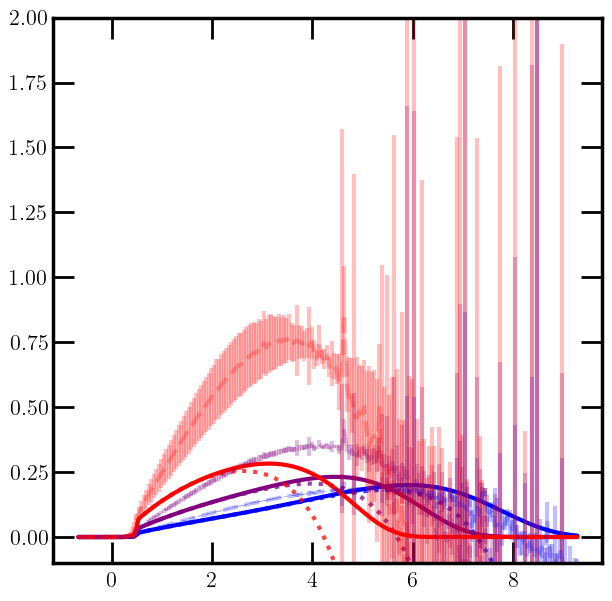

 468.5325:   9%|▉         | 450/5000 [01:13<09:28,  8.01it/s]

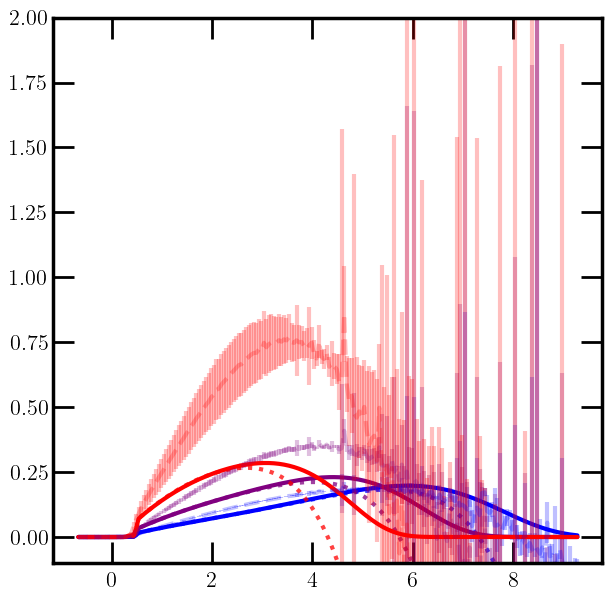

 437.0070:  10%|█         | 500/5000 [01:21<10:11,  7.36it/s]

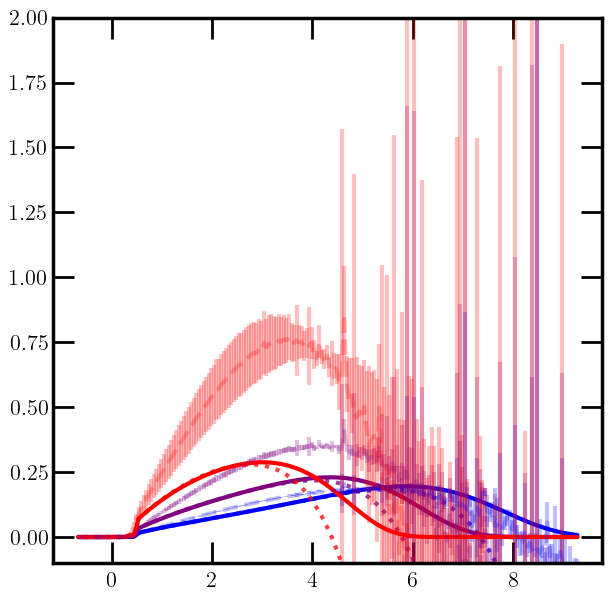

 406.2748:  11%|█         | 550/5000 [01:29<11:32,  6.43it/s]

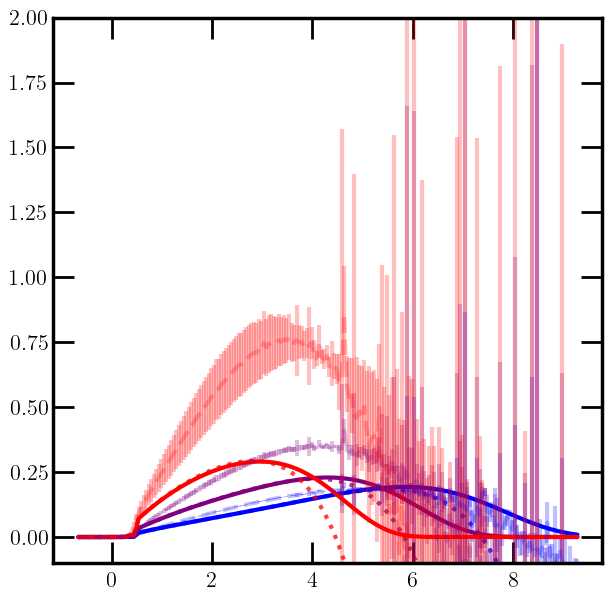

 376.3625:  12%|█▏        | 600/5000 [01:37<10:10,  7.21it/s]

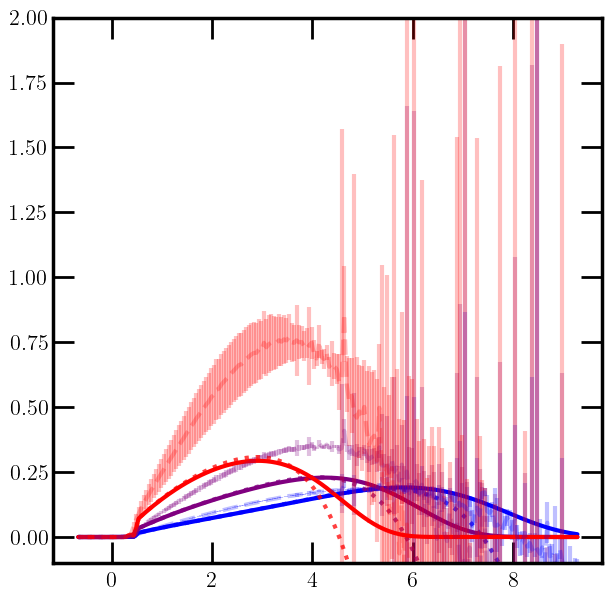

 347.3756:  13%|█▎        | 650/5000 [01:44<10:17,  7.05it/s]

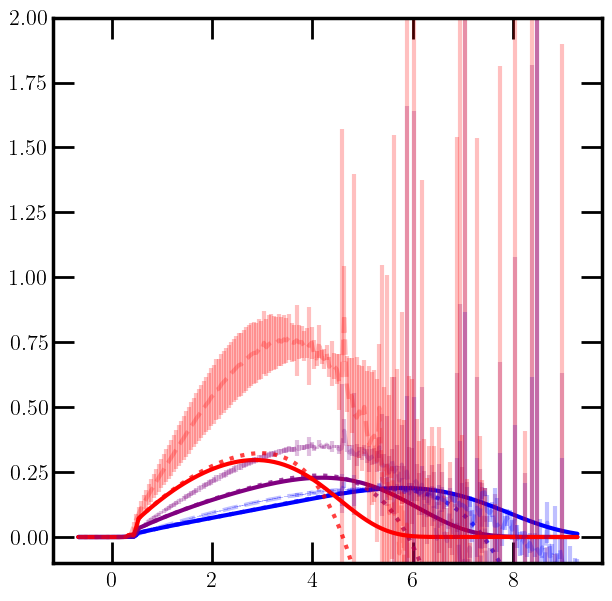

 319.4471:  14%|█▍        | 700/5000 [01:52<10:50,  6.61it/s]

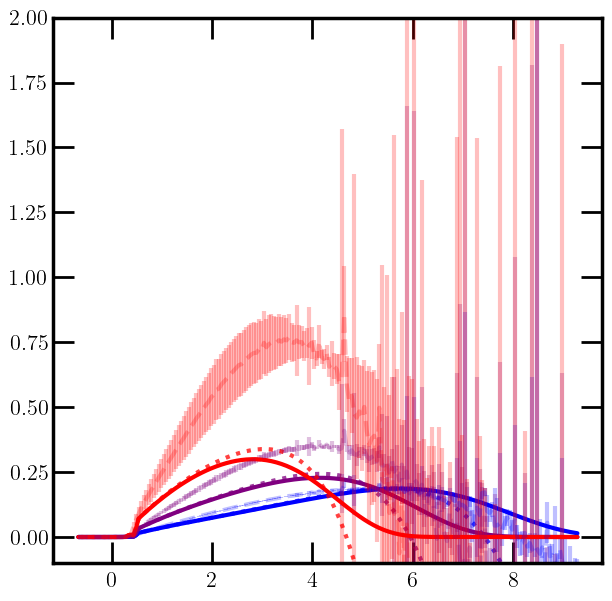

 292.7051:  15%|█▌        | 750/5000 [02:00<09:07,  7.76it/s]

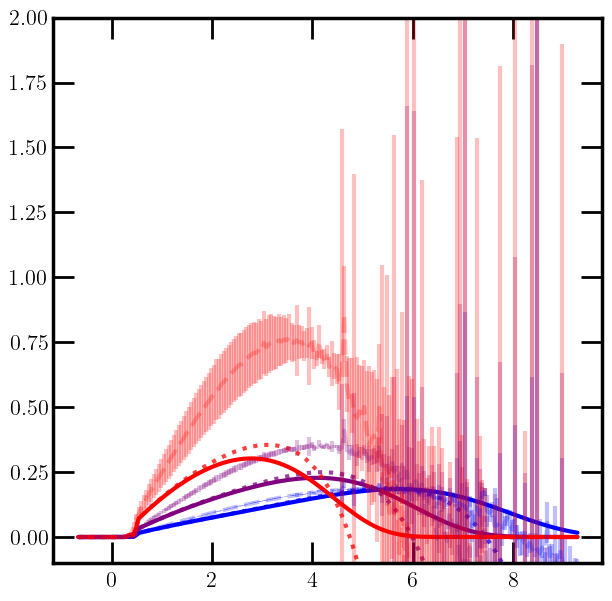

 267.2596:  16%|█▌        | 800/5000 [02:07<09:32,  7.34it/s]

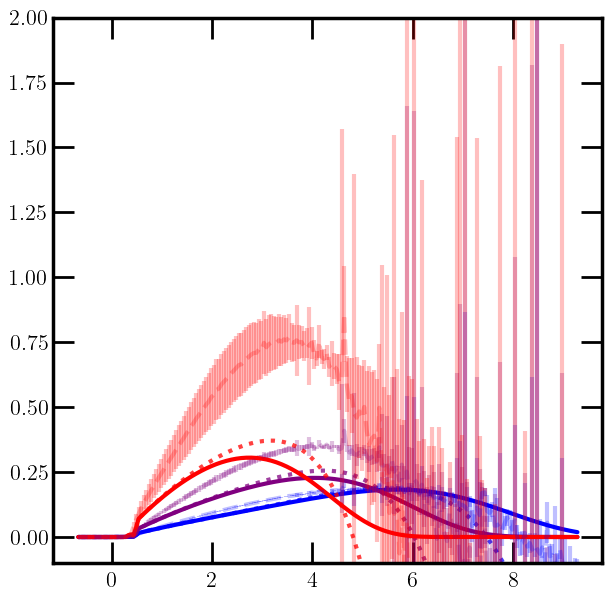

 243.1965:  17%|█▋        | 850/5000 [02:14<08:43,  7.93it/s]

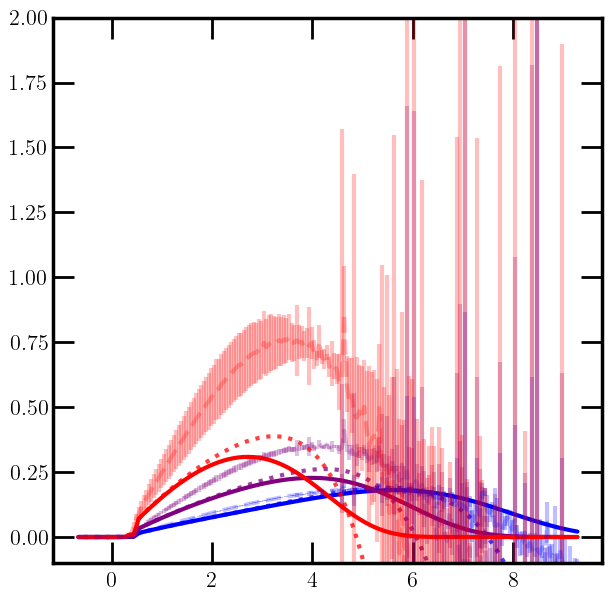

 220.5761:  18%|█▊        | 900/5000 [02:22<08:35,  7.95it/s]

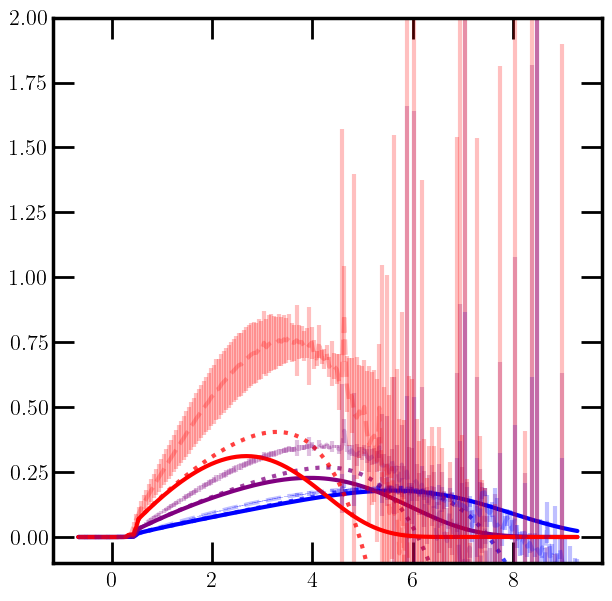

 199.1786:  19%|█▉        | 950/5000 [02:29<09:24,  7.18it/s]

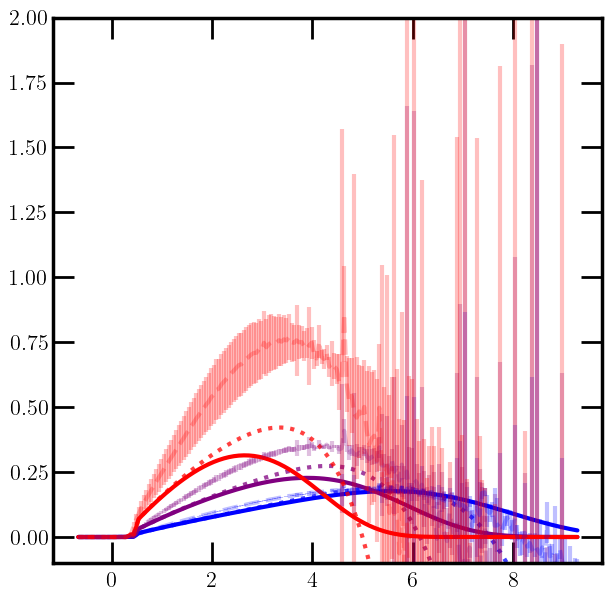

 179.4068:  20%|██        | 1000/5000 [02:37<09:05,  7.34it/s]

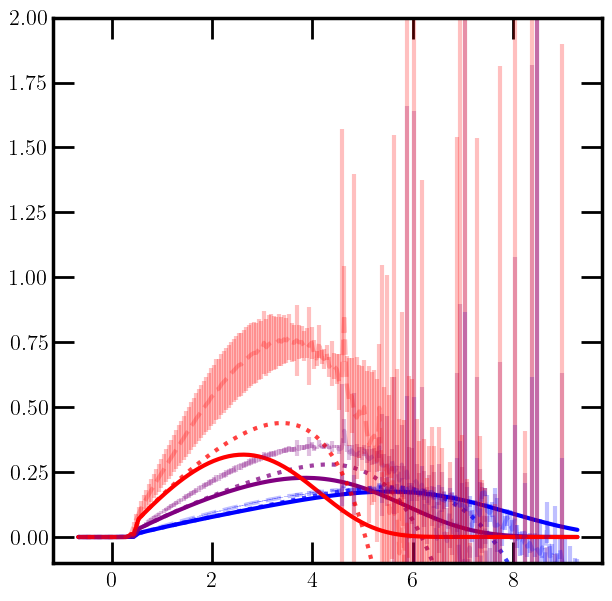

 161.1350:  21%|██        | 1050/5000 [02:46<10:07,  6.50it/s]

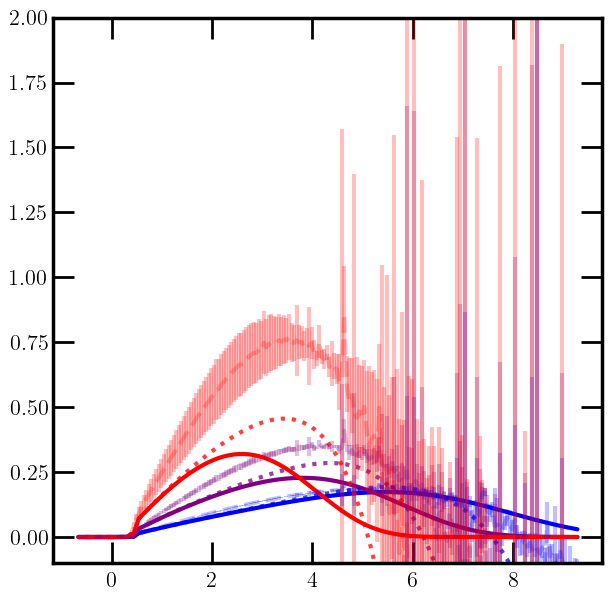

 144.3335:  22%|██▏       | 1100/5000 [02:53<08:35,  7.57it/s]

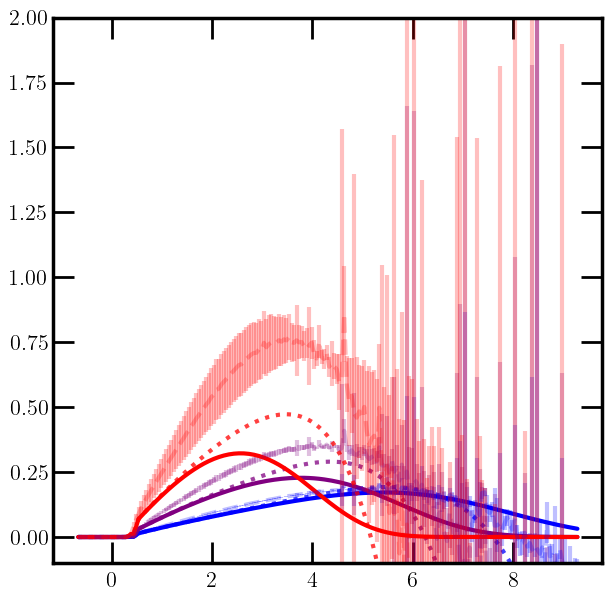

 128.9656:  23%|██▎       | 1150/5000 [03:01<08:18,  7.73it/s]

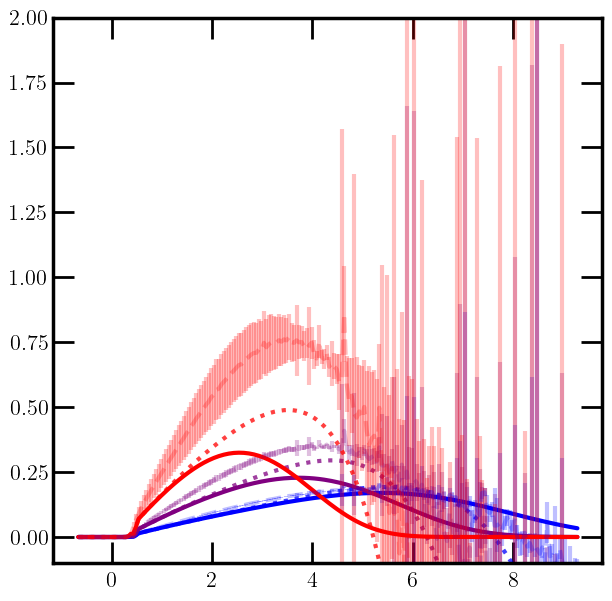

 114.9830:  24%|██▍       | 1200/5000 [03:08<11:25,  5.55it/s]

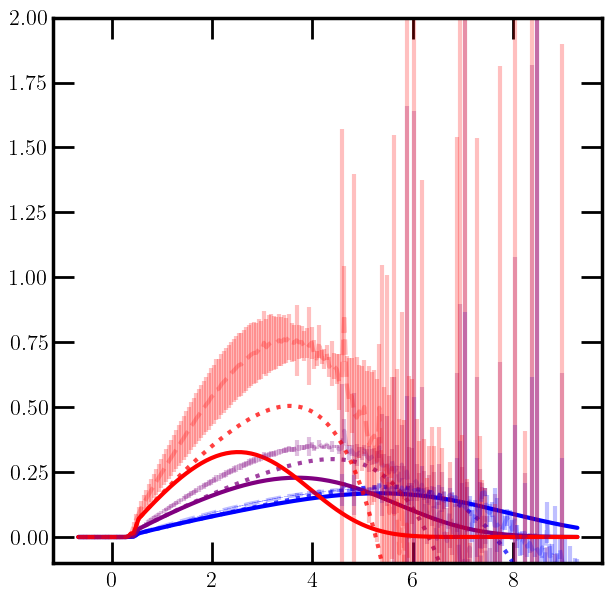

 102.3260:  25%|██▌       | 1250/5000 [03:17<09:22,  6.67it/s]

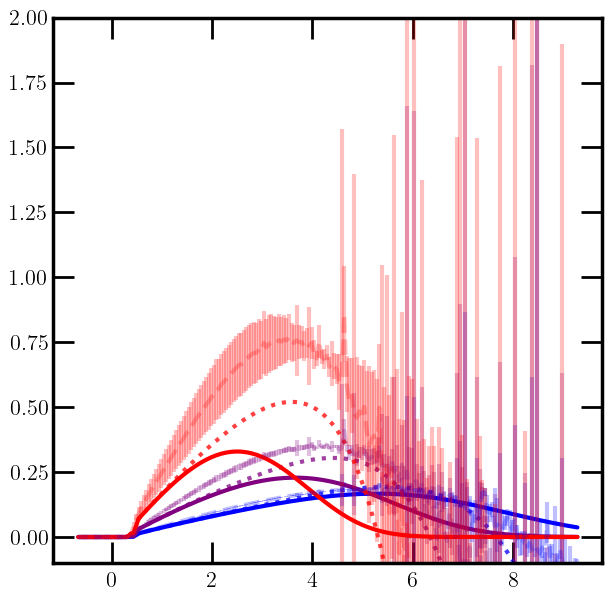

 90.9278:  26%|██▌       | 1300/5000 [03:24<09:49,  6.28it/s] 

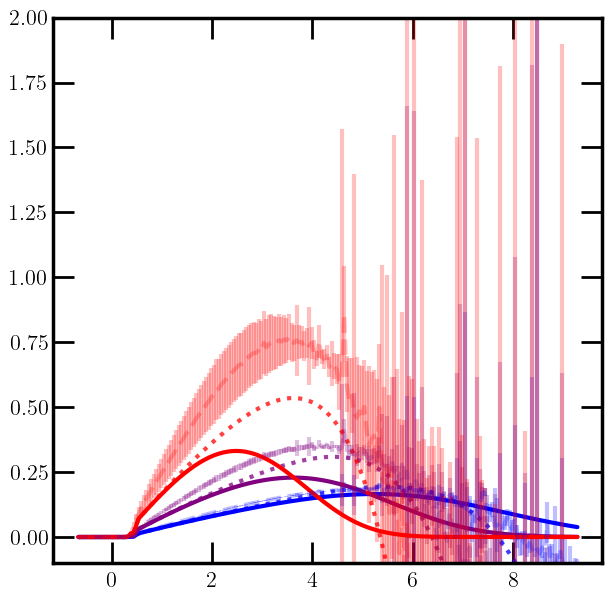

 80.7154:  27%|██▋       | 1350/5000 [03:33<10:21,  5.87it/s]

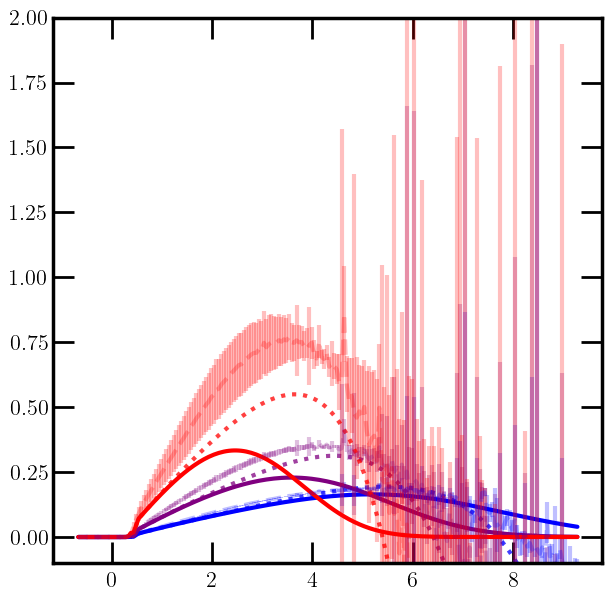

 71.6108:  28%|██▊       | 1400/5000 [03:41<08:15,  7.26it/s]

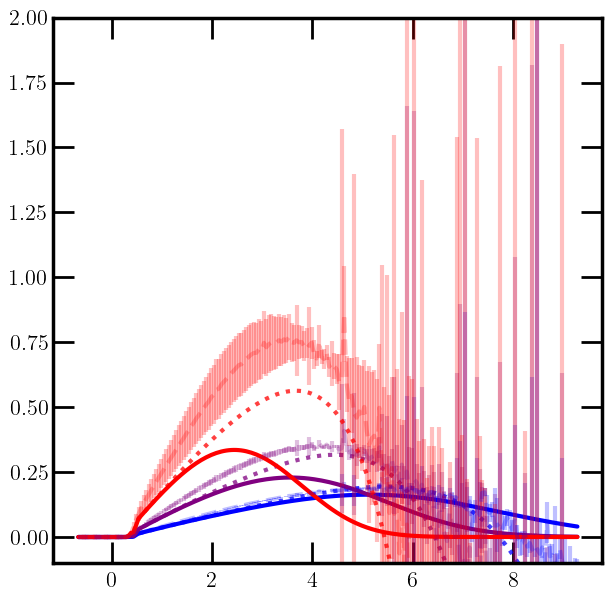

 63.5347:  29%|██▉       | 1450/5000 [03:50<09:25,  6.27it/s]

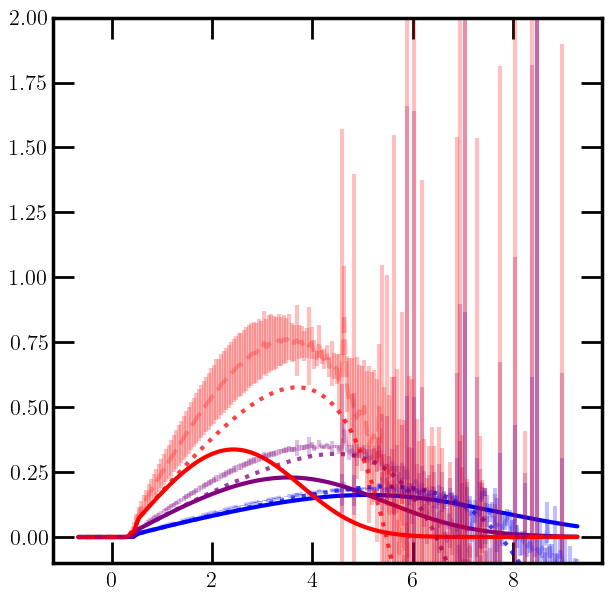

 56.4133:  30%|███       | 1500/5000 [03:59<08:45,  6.65it/s]

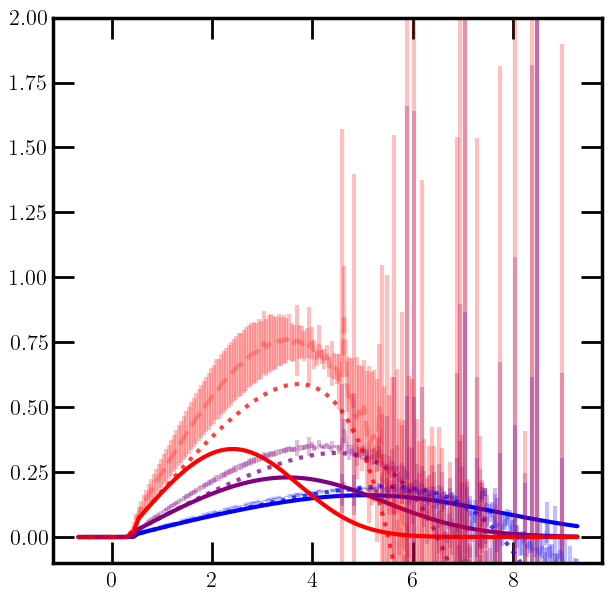

 50.1511:  31%|███       | 1550/5000 [04:09<09:23,  6.12it/s]

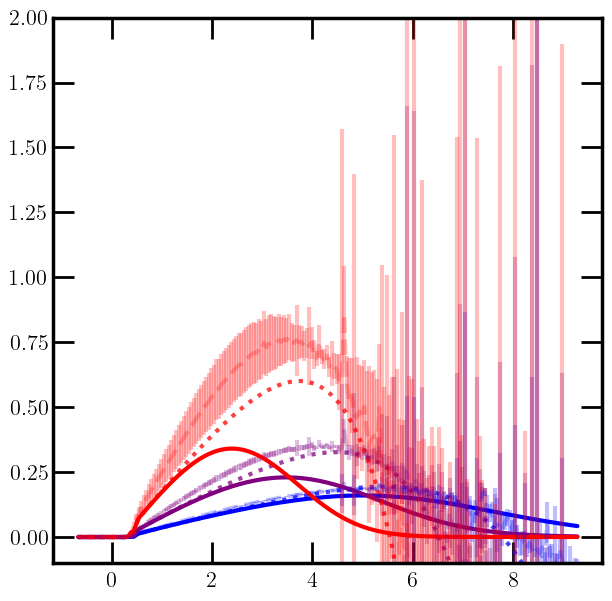

 44.6767:  32%|███▏      | 1600/5000 [04:17<08:40,  6.53it/s]

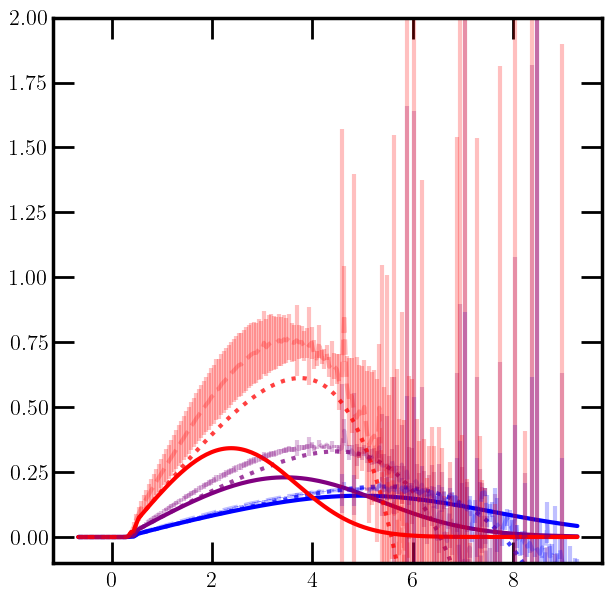

 39.9135:  33%|███▎      | 1650/5000 [04:25<09:29,  5.88it/s]

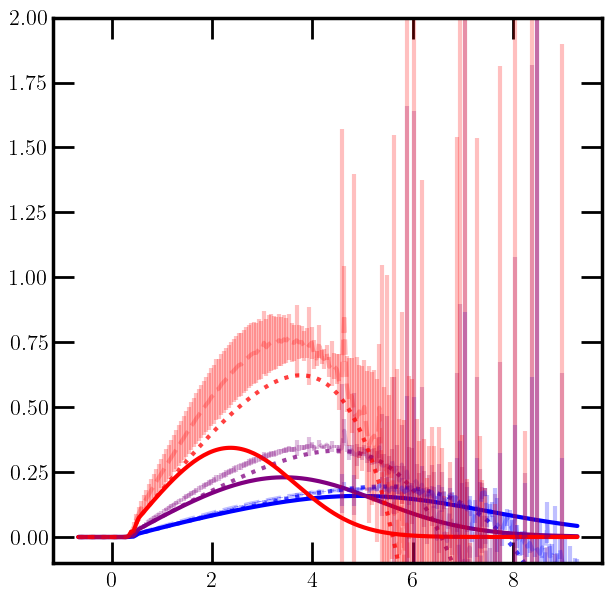

 35.7884:  34%|███▍      | 1700/5000 [04:34<08:04,  6.81it/s]

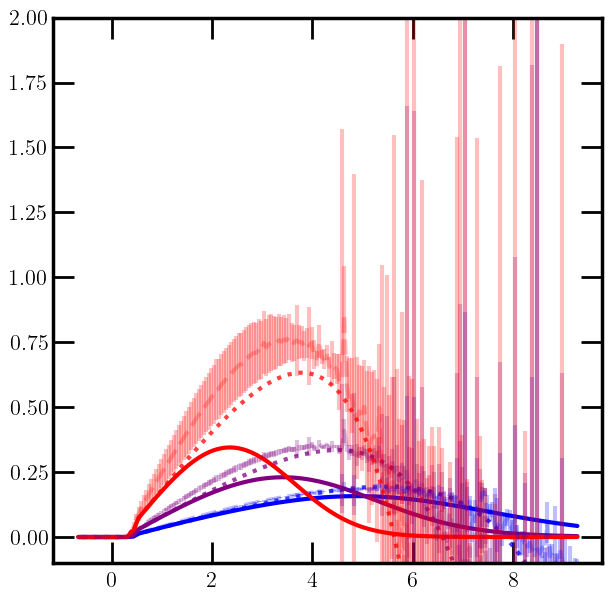

 32.2317:  35%|███▌      | 1750/5000 [04:42<10:06,  5.36it/s]

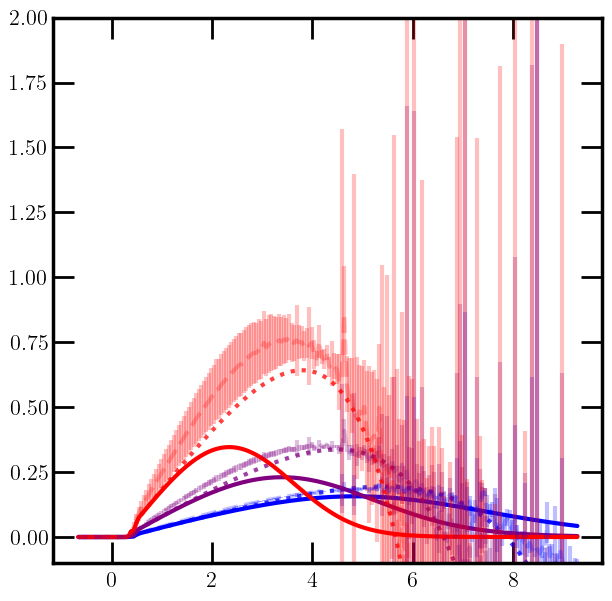

 29.1784:  36%|███▌      | 1800/5000 [04:51<08:48,  6.06it/s]

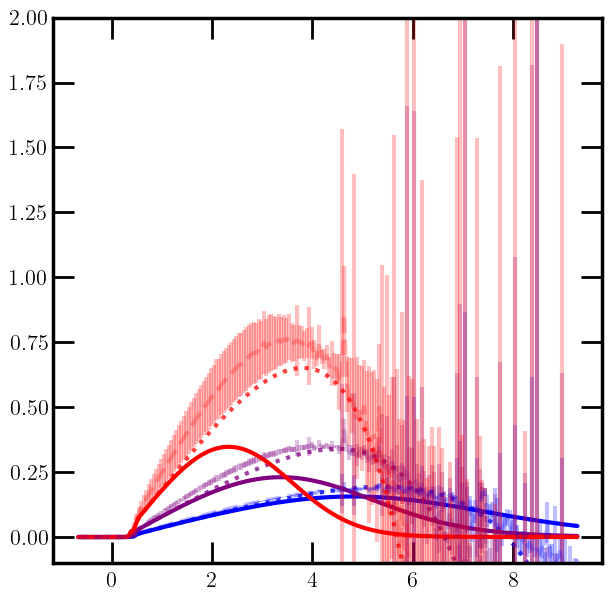

 26.5683:  37%|███▋      | 1850/5000 [04:59<07:01,  7.48it/s]

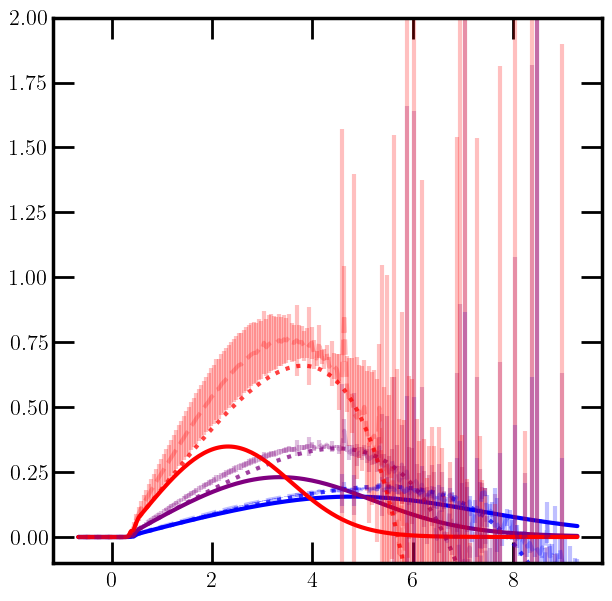

 24.3456:  38%|███▊      | 1900/5000 [05:08<06:52,  7.51it/s]

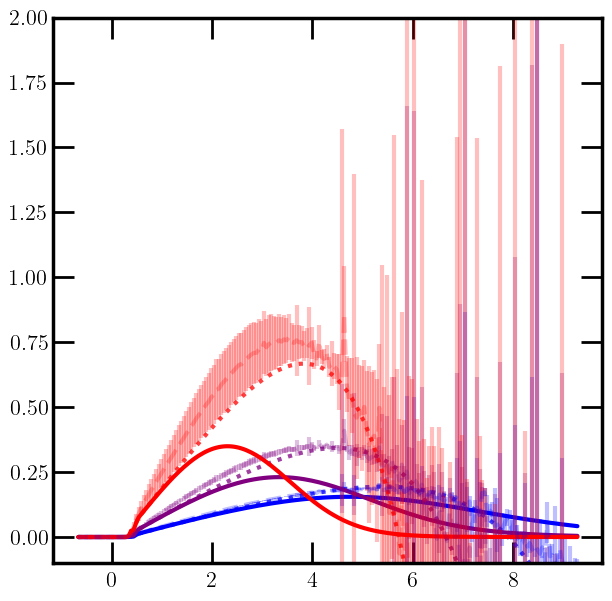

 22.4598:  39%|███▉      | 1950/5000 [05:16<07:11,  7.07it/s]

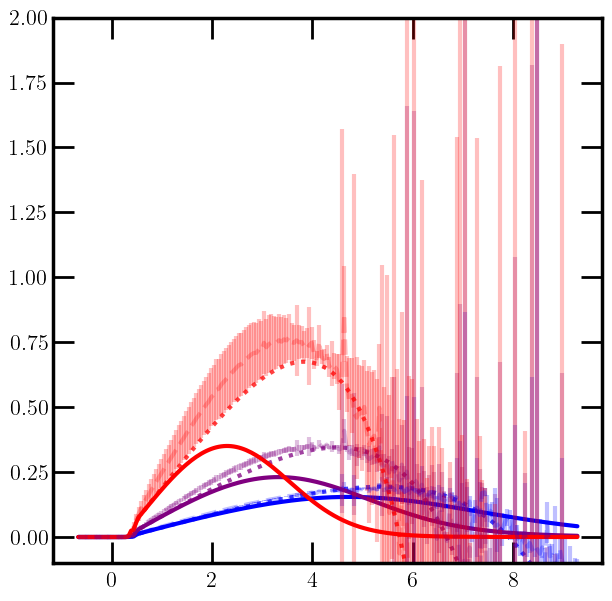

 20.8651:  40%|████      | 2000/5000 [05:24<07:11,  6.95it/s]

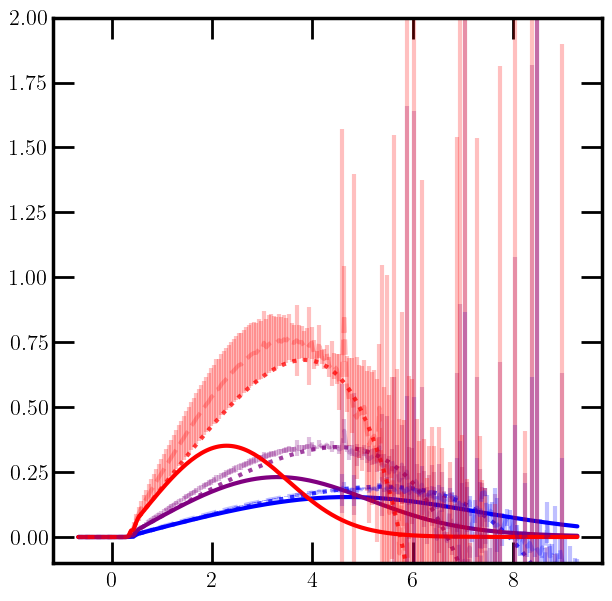

 19.5204:  41%|████      | 2050/5000 [05:32<07:23,  6.65it/s]

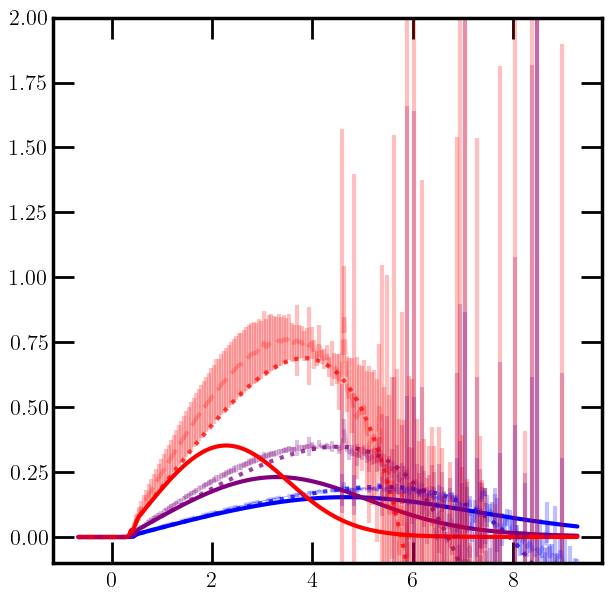

 18.3891:  42%|████▏     | 2100/5000 [05:41<08:24,  5.75it/s]

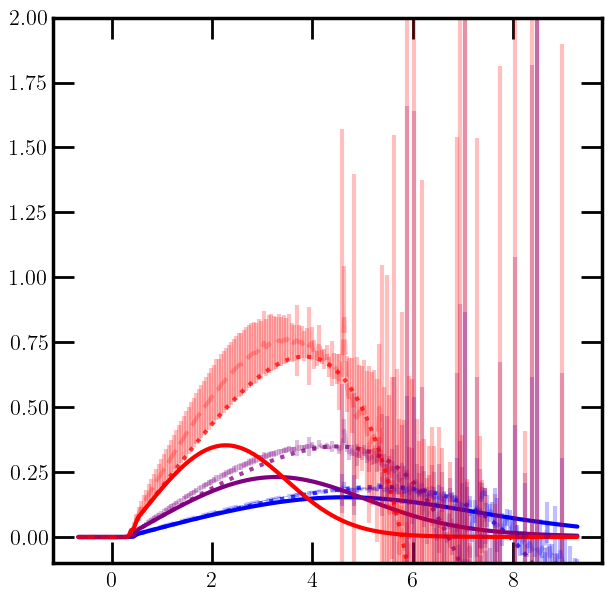

 17.4298:  43%|████▎     | 2150/5000 [05:50<06:58,  6.81it/s]

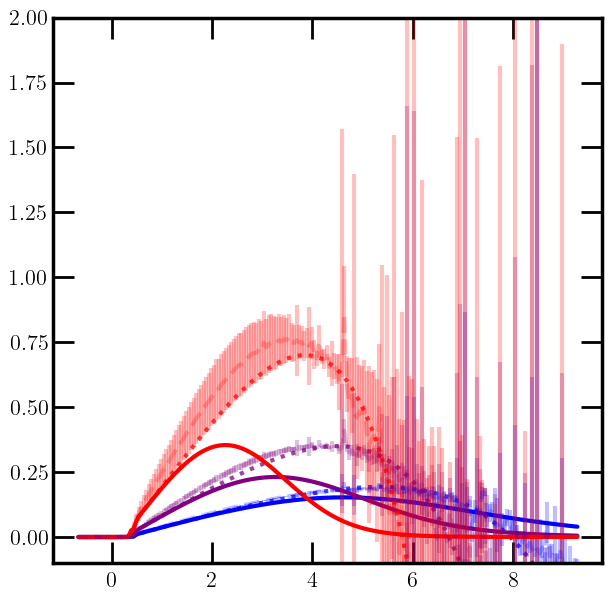

 16.3326:  44%|████▍     | 2200/5000 [05:58<06:47,  6.86it/s]

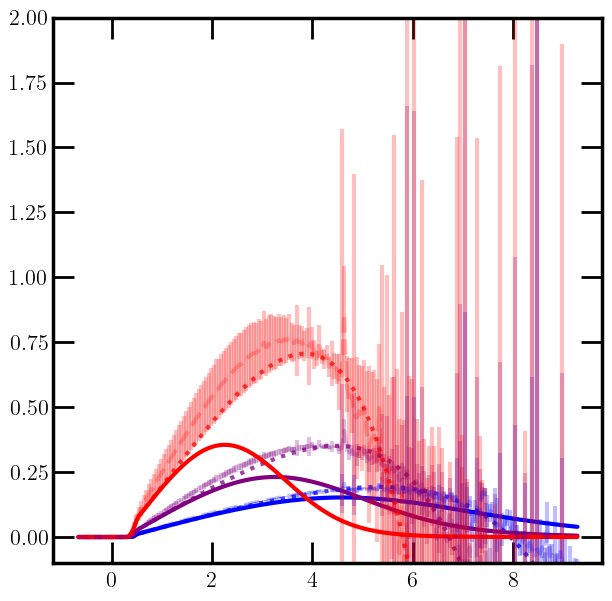

 15.5589:  45%|████▌     | 2250/5000 [06:05<06:10,  7.41it/s]

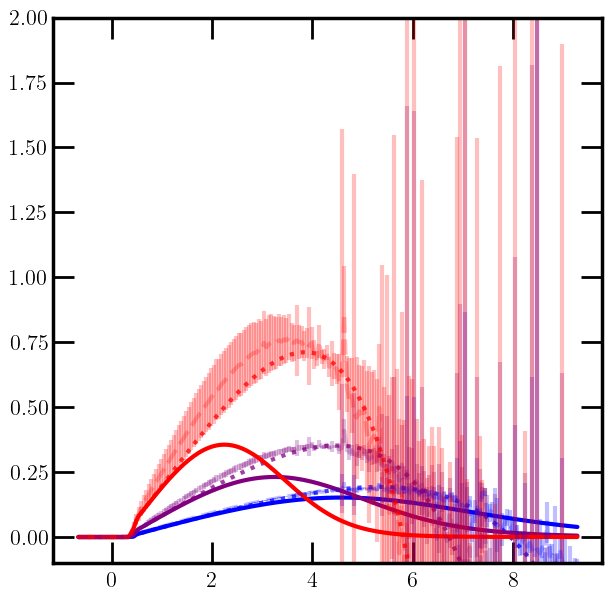

 14.8945:  46%|████▌     | 2300/5000 [06:13<06:16,  7.18it/s]

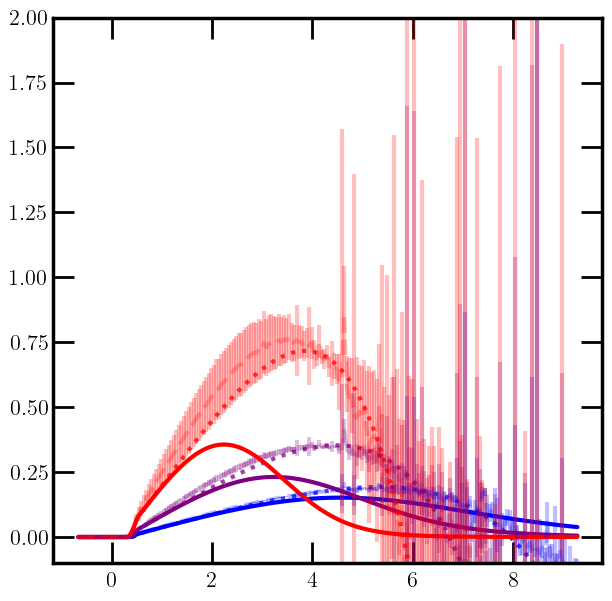

 14.3211:  47%|████▋     | 2350/5000 [06:20<05:53,  7.49it/s]

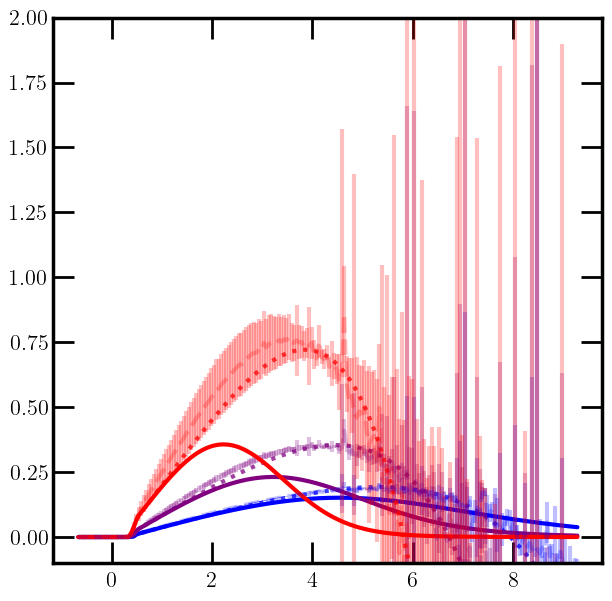

 14.0046:  48%|████▊     | 2381/5000 [06:26<07:04,  6.17it/s]


KeyboardInterrupt: 

In [7]:
# Initialize Optimizer
opt = optax.adamw(lr, weight_decay= weight_decay)
opt_state = opt.init(params)

# Initialize logs
losses = []
params_log = []
params_log.append(params)
g_coeffs_log = [params["g_coeffs"]]
g_star_log = [params["g_star"]]
thetas_log = [params["thetas"]]

@jax.jit
def train_step(epoch, params, opt_state, random_key):
    
    # Boilerplate, in case we need random numbers
    key, subkey = jax.random.split(random_key)

    # Get the gradients
    loss, grad_loss = jax.value_and_grad(loss_function)(params)

    # Jax Grad Descent stuff
    updates, opt_state = opt.update(grad_loss, opt_state, params=params)
    params = optax.apply_updates(params, updates)

    

    # Save the random key for the seed for the next epoch
    return params, opt_state, loss, subkey

# Loop
epochs_tqdm = tqdm(range(epochs))
for epoch in epochs_tqdm:



    if epoch % 50 == 0:
        fig, ax = newplot("full")
        q_vals = q_vmap2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])
        q_taylor_vals = CHOSEN_Q_VMAP2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])

        for (k, key) in enumerate(keys):
            y, yerr = data_dict[key]
            y = y[:,0]
            yerr = yerr[:,0]
            plt.errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
            plt.plot(t_bin_centers, q_vals[k], color = colors[k])
            plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")


        plt.ylim(-0.1, 2e0)
        # plt.xscale("log")
        # plt.yscale("log")
        plt.show()



    params, opt_state, loss, jax_key = train_step(epoch, params, opt_state, jax_key)


    losses.append(loss)
    g_star_log.append(params['g_star'])
    g_coeffs_log.append(params['g_coeffs'])
    thetas_log.append(params['thetas'])
    params_log.append(params)


    epochs_tqdm.set_description(f"{losses[-1].item() : .4f}")
    # print(g_coeffs_log[-1])
    # print(g_star_log[-1])
    # print(thetas_log[-1])





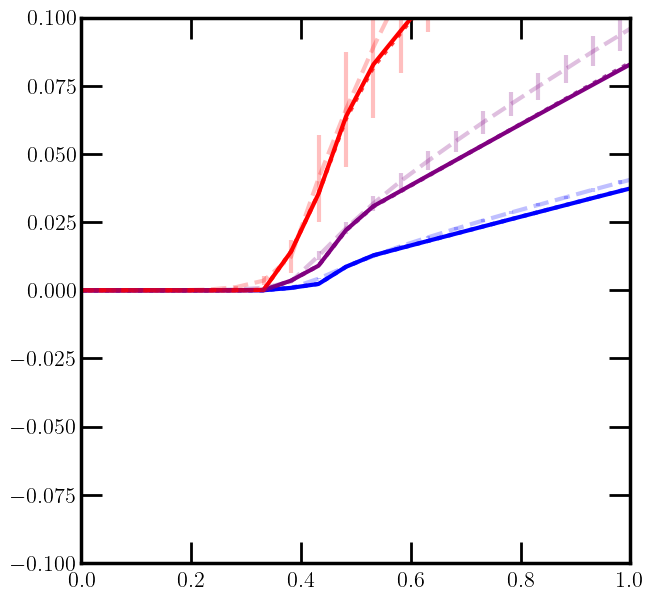

{'g_coeffs': Array([[-0.08653332, -0.25363567,  0.00968014,  0.03734191],
       [ 0.09997816, -0.10300104,  0.09474984, -0.03234356]],      dtype=float32), 'g_star': Array([[ 0.34306416, -1.063176  ,  0.06441174, -0.00684862],
       [-0.5823718 , -0.53548455, -0.2306692 , -0.32073444]],      dtype=float32), 'thetas': Array([0.46785304, 0.3849239 ], dtype=float32)}


In [8]:
fig, ax = newplot("full")
q_vals = q_vmap2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])
q_taylor_vals = CHOSEN_Q_VMAP2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])

for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]
    plt.errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
    plt.plot(t_bin_centers, q_vals[k], color = colors[k])
    plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")

plt.xlim(0, 1)
plt.ylim(-0.1, 0.1)
# plt.xscale("log")
# plt.yscale("log")
plt.show()

print(params)


In [ ]:
print(loss_function(params_log[0]))
print(loss_function(params_log[1]))
print(loss_function(params_log[2]))

y_preds = CHOSEN_Q_VMAP2(t_bin_centers, keys, params_log[1]["g_star"], params_log[1]["g_coeffs"], params_log[1]["thetas"])
y_preds = jnp.nan_to_num(y_preds)

y_preds = CHOSEN_Q_VMAP2(t_bin_centers, keys, params_log[1]["g_star"], params_log[1]["g_coeffs"], params_log[1]["thetas"])
plt.plot(t_bin_centers, y_preds[1])